In [11]:
import pandas as pd
from tqdm import tqdm
import os, sys
import warnings
import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns


warnings.filterwarnings('ignore')

dataFolder = 'data/'
dataList = [dataFolder + f for f in os.listdir(dataFolder) if f.endswith('.csv')]


def read_csv(file: str) -> pd.DataFrame:
    return pd.read_csv(file)

def pre_processing(df:pd.DataFrame, drop_col:list=None, one_hot_col:list=None, date_col:list=None, convert_col:list=None) -> pd.DataFrame:
    
    # drop id column
    if drop_col is not None:
        for col in drop_col:
            df = df.drop(col, axis=1)
            
    # one-hot encoding 
    if one_hot_col is not None:
        for col in one_hot_col:
            df[col] = df[col].astype('category').cat.codes
    
    # date convert
    if date_col is not None:
        for date in date_col:
            df[date] = pd.to_datetime(df[date])
            
    if convert_col is not None:
        for col in convert_col:
            df[col] = df[col].astype('float')
            
    return df

def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

## 匯入資料

In [12]:
reportDf = read_csv(dataList[0])
birthDf = read_csv(dataList[1])
submissionDf = read_csv(dataList[2])
breedDf = read_csv(dataList[3])
specDf = read_csv(dataList[4])


## 分析資料中的缺失值，再決定要不要刪除 / 補值 

### 缺失值計算

In [13]:
for df in [reportDf, birthDf, submissionDf, breedDf, specDf]:
    print(get_df_name(df))
    print(df.shape)
    # 算出每個欄位的缺失值比例
    print(f"{df.isnull().sum() / len(df) * 100}\n")

reportDf
(37517, 21)
id                       0.000000
year                     0.000000
month                    0.000000
dairyFarm                0.000000
numOfCow                 0.000000
numOfCowFatherSemen      2.334941
numOfCowMotherSemen      9.553003
birthday                 0.000000
parity                   0.000000
dayOfLactation           0.002665
milkVolume              11.362849
lastDateOfBirth          0.002665
dayOfSampling            0.000000
ageOfTheMoon             0.000000
dateOfTest               0.000000
lastDateOfBreeding       4.094144
semenOfLastBreeding      4.094144
countOfBreeding          0.000000
lastDateOfChildbirth    46.432284
firstDateOfBreeding      3.814271
semenOfFirstBreeding     3.814271
dtype: float64

birthDf
(3761, 13)
numOfCow                    0.000000
dateOfChildbirth            0.000000
dateOfDryMilk              43.525658
firstNumOfCalf             77.293273
secondNumOfCalf            99.787291
numOfmonCow                81.122042
dateOfLo

### 資料分佈

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'month'}>],
       [<AxesSubplot:title={'center':'numOfCow'}>,
        <AxesSubplot:title={'center':'parity'}>,
        <AxesSubplot:title={'center':'dayOfLactation'}>],
       [<AxesSubplot:title={'center':'milkVolume'}>,
        <AxesSubplot:title={'center':'ageOfTheMoon'}>,
        <AxesSubplot:title={'center':'countOfBreeding'}>]], dtype=object)

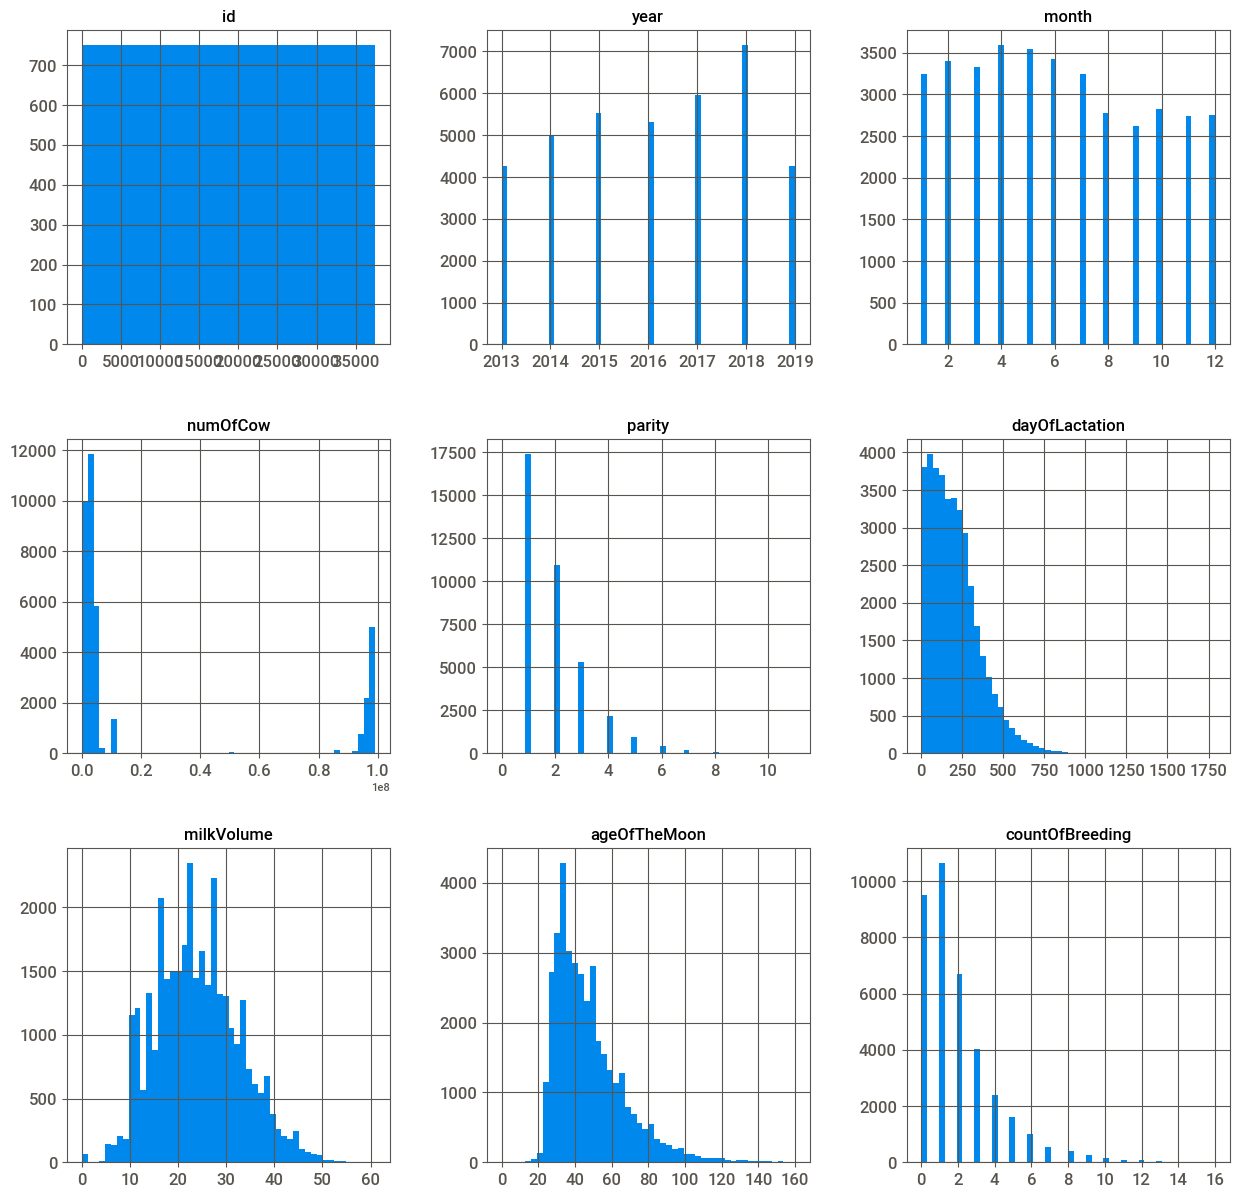

In [14]:
reportDf.hist(figsize=(15, 15), bins=50, xlabelsize=12, ylabelsize=12)

array([[<AxesSubplot:title={'center':'numOfCow'}>,
        <AxesSubplot:title={'center':'numOfmonCow'}>],
       [<AxesSubplot:title={'center':'parityOfCow'}>,
        <AxesSubplot:title={'center':'difficultyOfGivingBirth'}>]],
      dtype=object)

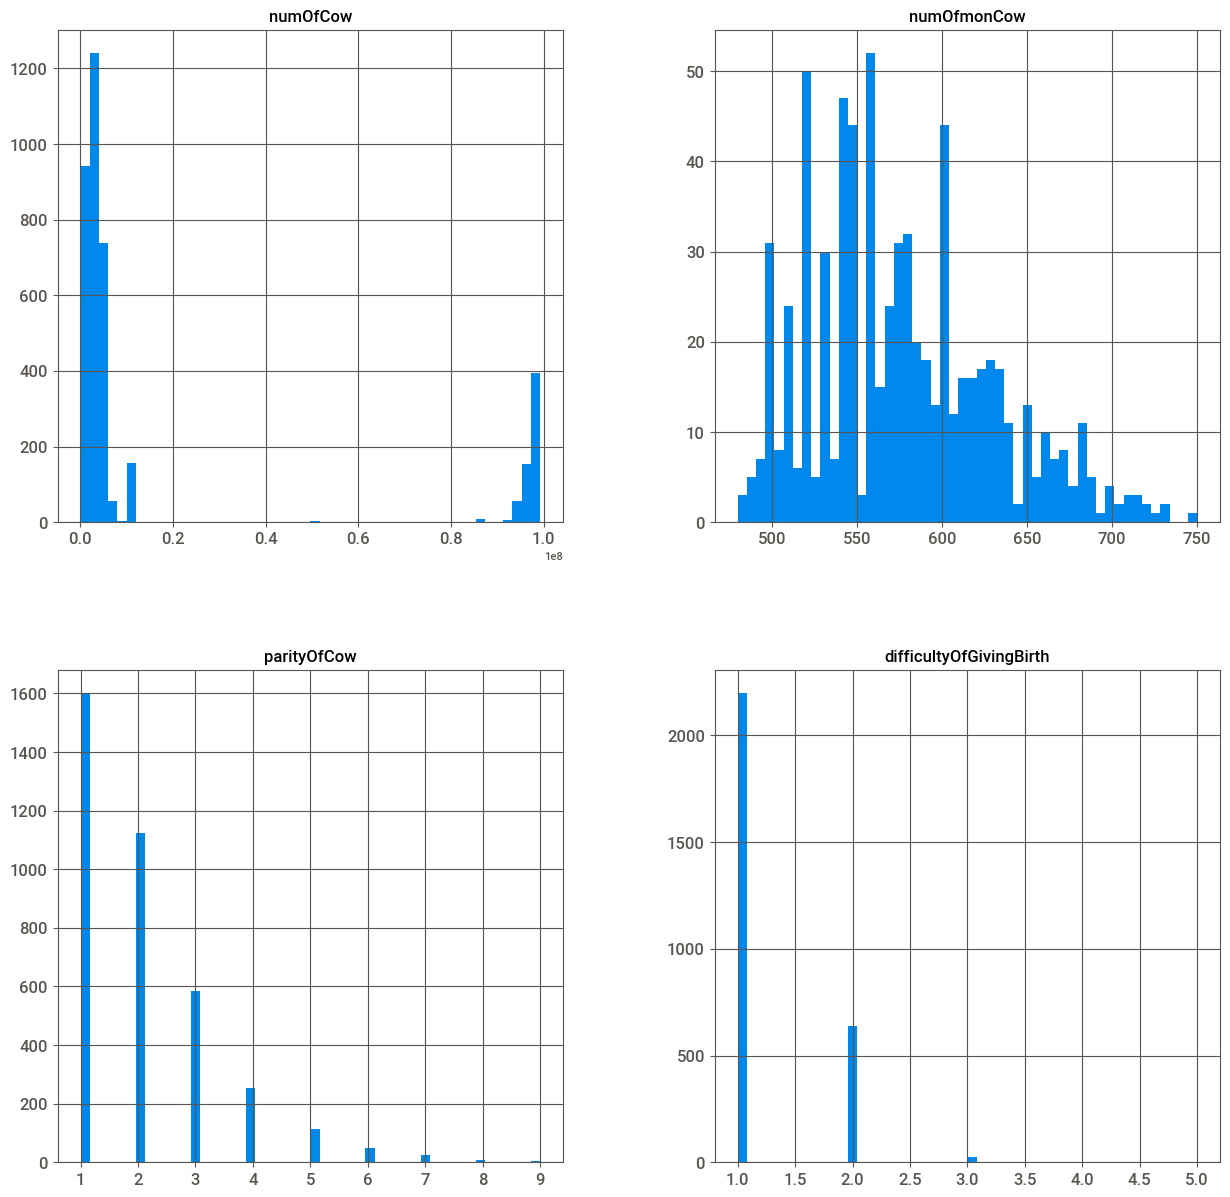

In [15]:
birthDf.hist(figsize=(15, 15), bins=50, xlabelsize=12, ylabelsize=12)

array([[<AxesSubplot:title={'center':'numOfCow'}>,
        <AxesSubplot:title={'center':'pregnancyTest'}>]], dtype=object)

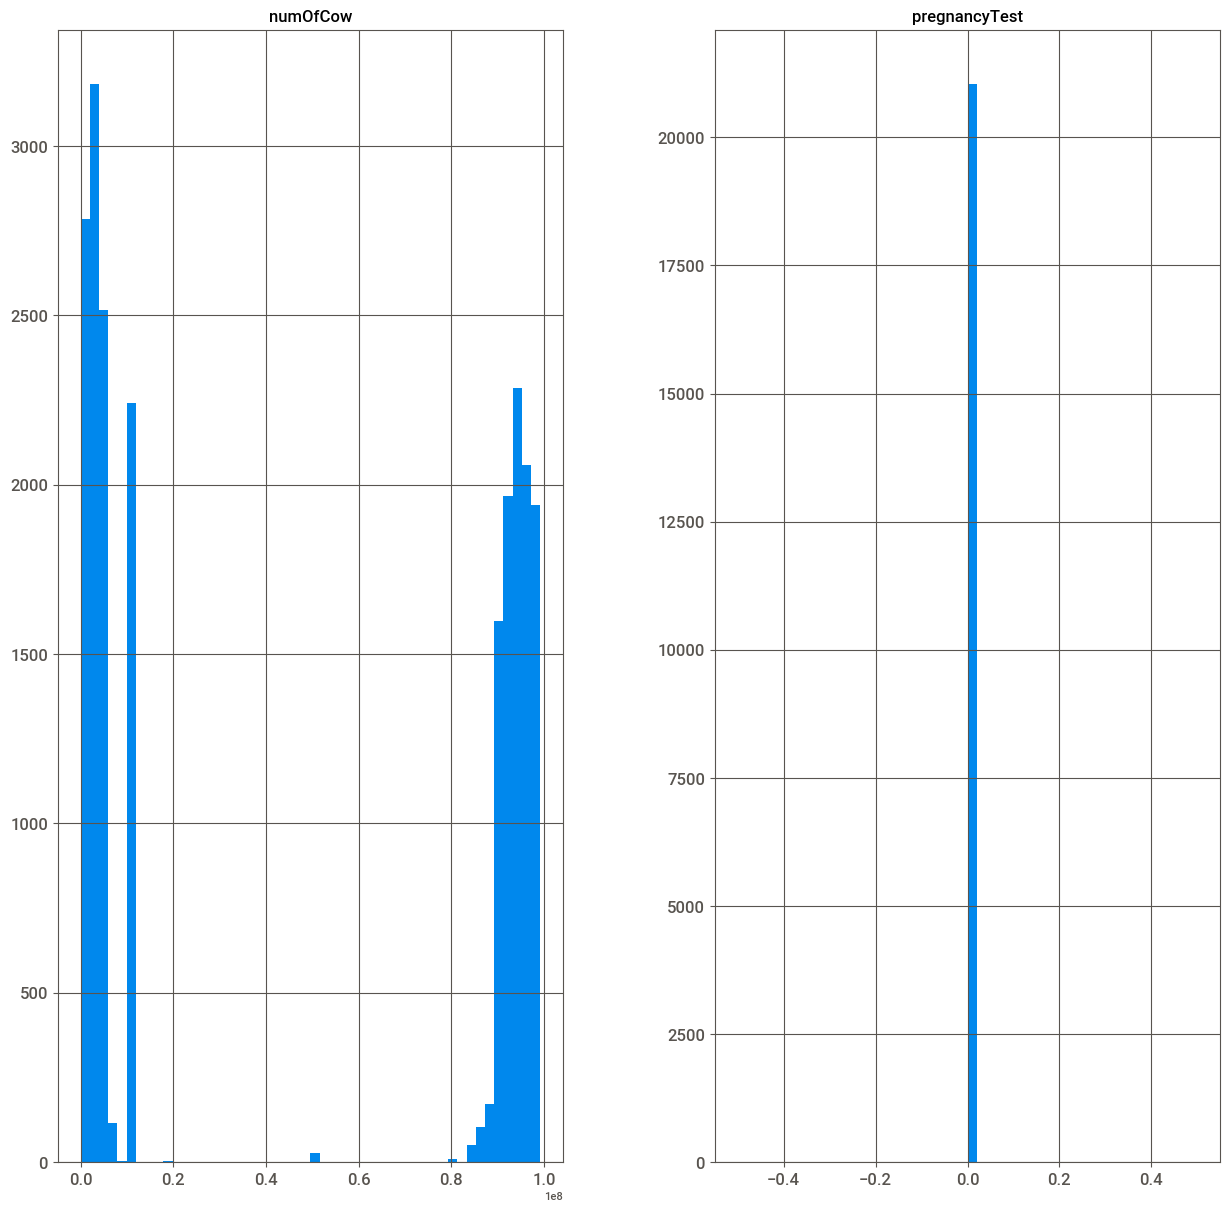

In [16]:
breedDf.hist(figsize=(15, 15), bins=50, xlabelsize=12, ylabelsize=12)

array([[<AxesSubplot:title={'center':'numOfCow'}>]], dtype=object)

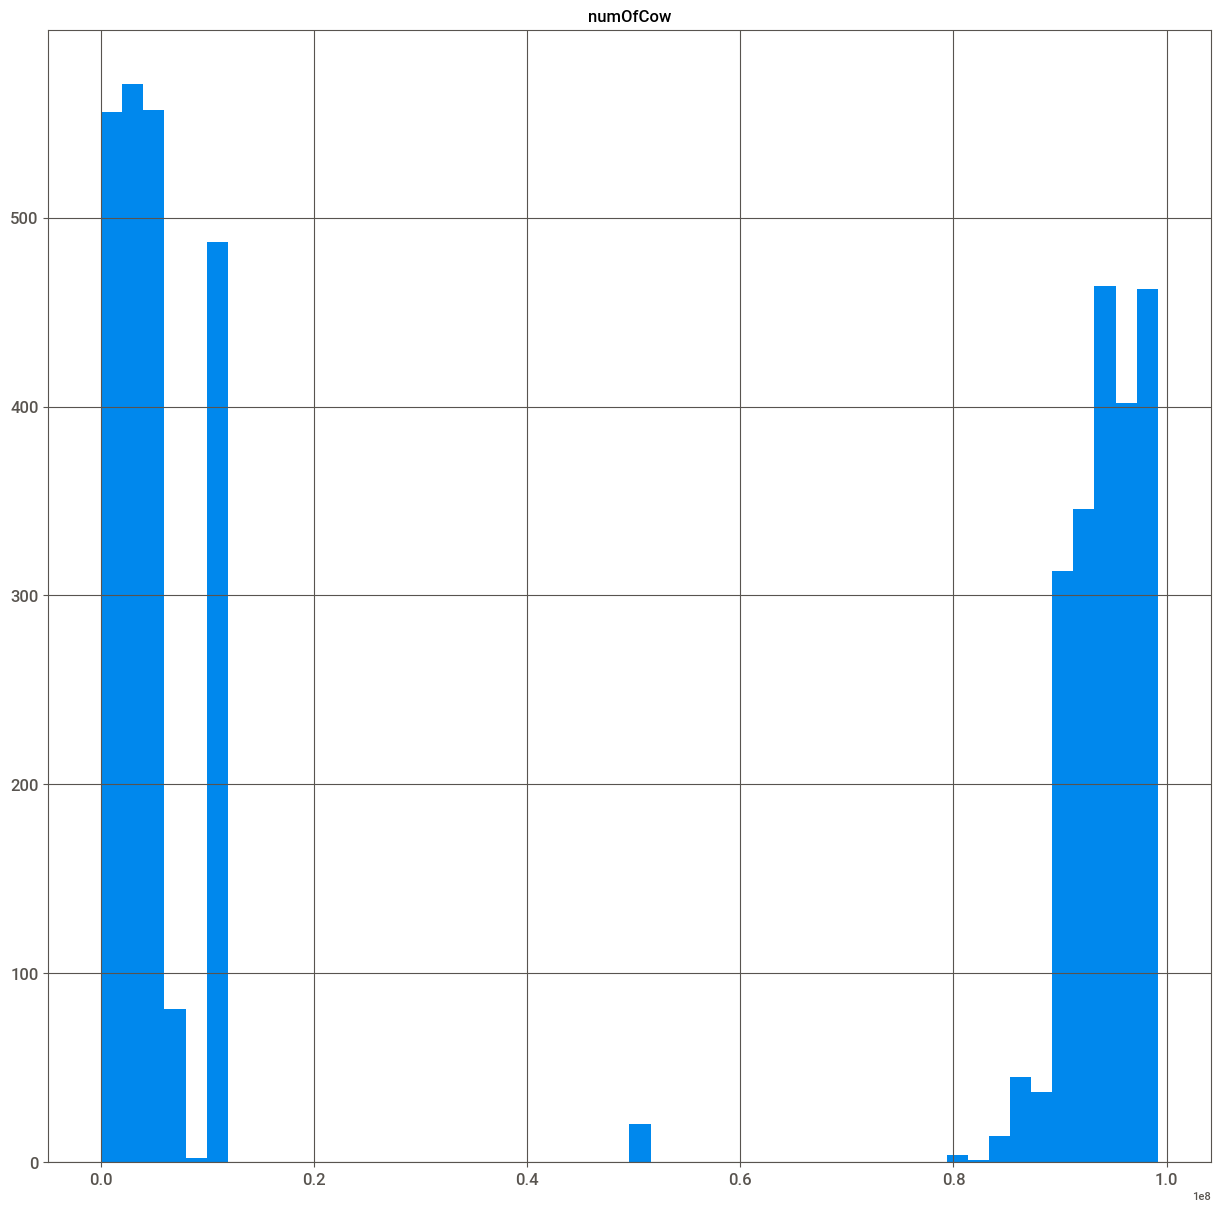

In [17]:
specDf.hist(figsize=(15, 15), bins=50, xlabelsize=12, ylabelsize=12)

### 目前 dataset 和 preidct target 的相關性

<AxesSubplot:>

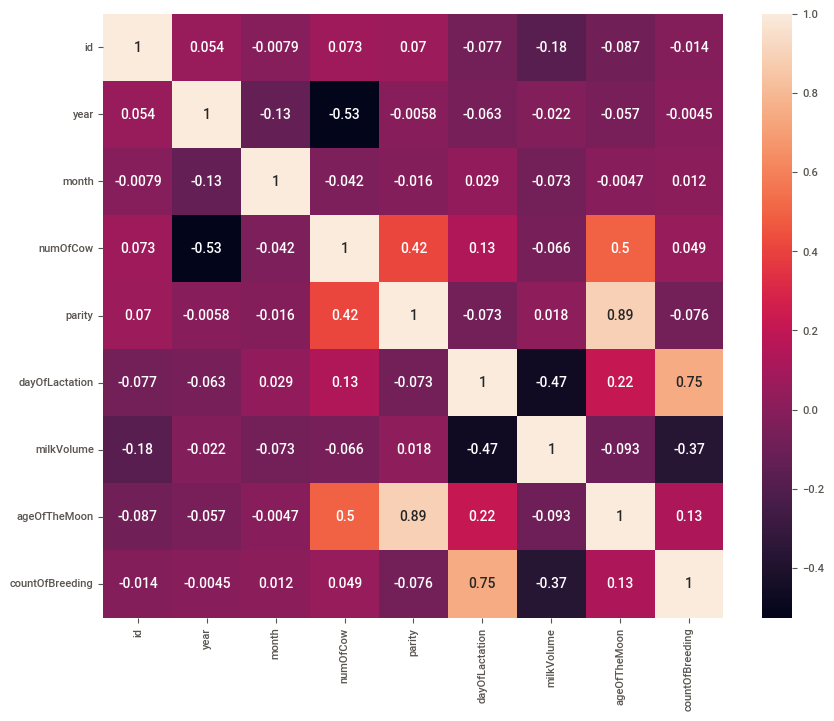

In [18]:
#使用seaborn的 heatmap 來看相關性
plt.figure(figsize=(10, 8))
sns.heatmap(reportDf.corr(), annot=True)

In [19]:
reportDf.columns

Index(['id', 'year', 'month', 'dairyFarm', 'numOfCow', 'numOfCowFatherSemen',
       'numOfCowMotherSemen', 'birthday', 'parity', 'dayOfLactation',
       'milkVolume', 'lastDateOfBirth', 'dayOfSampling', 'ageOfTheMoon',
       'dateOfTest', 'lastDateOfBreeding', 'semenOfLastBreeding',
       'countOfBreeding', 'lastDateOfChildbirth', 'firstDateOfBreeding',
       'semenOfFirstBreeding'],
      dtype='object')

## 資料前處理

* 我們從上面的分析得知，有些資料是有缺失值的，還有一些欄位是沒有意義的，所以我們要先處理這些資料

### 刪除缺失值的欄位

```
    * reportDf -> lastDateOfChildbirth, id, dateOfTest
    * birthDf -> 'secondNumOfCalf', 'countOfwomb', 'dateOfLogin', 'firstNumOfCalf', 'sizeOfCalf', 'genderOfCalf'
    * breedDf -> 'dateOfLogin', 'pregnancyTest', 'typeOfSemen'
    * specDf -> 'dateOfLogin', 'comment'
```

### 補值

* 發現目標 milkVolume 有一部分的資料是 0, 因為是重要的資料，所以我們要先處理這些資料

<AxesSubplot:title={'center':'milkVolume'}, ylabel='Frequency'>

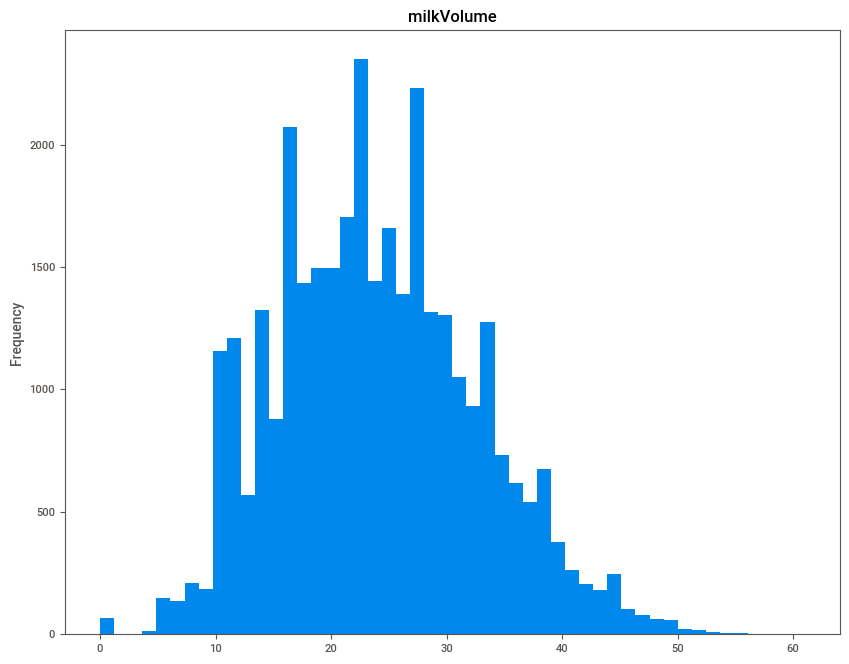

In [20]:
reportDf['milkVolume'].plot(kind='hist', bins=50, figsize=(10, 8), title='milkVolume')

#### plot 出每個牧場的 milkVolume 情況

<AxesSubplot:title={'center':'Mean milkVolume with different dairyFarm and year'}, xlabel='dairyFarm,year'>

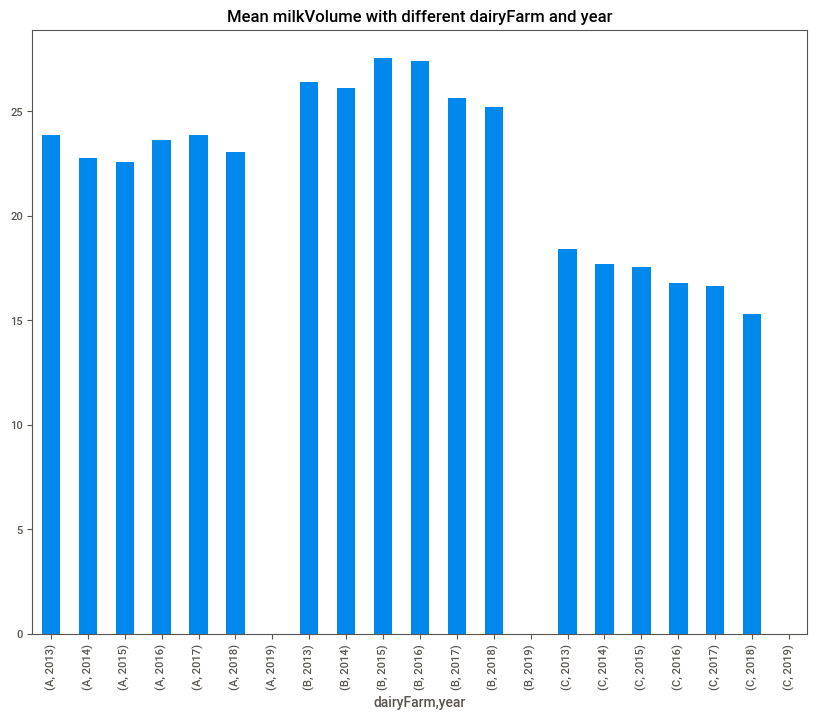

In [21]:
reportDf.groupby(['dairyFarm', 'year'])['milkVolume'].mean().plot(kind='bar', figsize=(10, 8), \
    title='Mean milkVolume with different dairyFarm and year')

<AxesSubplot:title={'center':'Mean milkVolume with different dairyFarm and month'}, xlabel='dairyFarm,month'>

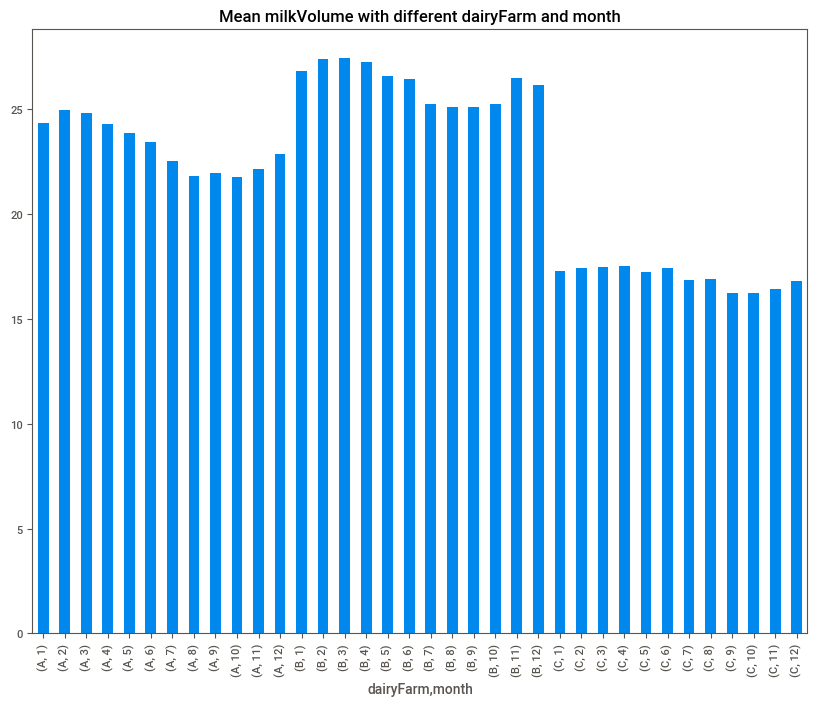

In [22]:
reportDf.groupby(['dairyFarm', 'month'])['milkVolume'].mean().plot(kind='bar', figsize=(10, 8), title='Mean milkVolume with different dairyFarm and month')

#### One-Hot Encoding map

```

preReportDf

- dairyFarm {A: 0, B: 1, C: 2}

---

preBirthDf

- genderOfCalf {公：1，母：2, 未知：0}
- dairyFarm {A: 0 , B: 1, C: 2}
- sizeOfCalf {S：3, M：2, L：1, 未知： 0}

---

preSpecDf

- typeOfSituation { C:2, D:3, N:4 ,1:0, 2:1}
- dairyFarm {A: 0 , B: 1, C: 2}

---

preBreedDf

- dairyFarm {A: 0 , B: 1, C: 2}

```


#### Preprocessing main

In [23]:
reportDf.numOfCowMotherSemen.value_counts()

外購            2231
進口             436
96174165.0     159
95040473       149
97171306.0     125
              ... 
96174168.0       1
1112031          1
3114009          1
3114052          1
3040216          1
Name: numOfCowMotherSemen, Length: 1266, dtype: int64

In [24]:
# drop year column == 2019，因為沒有資料
reportDf = reportDf[reportDf['year'] != 2019]
preReportDf = pre_processing(df=reportDf, drop_col=['id', 'dateOfTest', 'lastDateOfChildbirth'], one_hot_col=['dairyFarm', 'numOfCowFatherSemen','semenOfLastBreeding', 'numOfCowMotherSemen', 'semenOfFirstBreeding' ], \
    date_col=['birthday', 'lastDateOfBirth', 'dayOfSampling', 'lastDateOfBreeding', 'firstDateOfBreeding'],\
    convert_col=['numOfCowFatherSemen', 'numOfCowMotherSemen'])  
    
preBirthDf = pre_processing(df=birthDf, drop_col=['secondNumOfCalf', 'countOfwomb', 'dateOfLogin', 'firstNumOfCalf', 'sizeOfCalf', 'genderOfCalf', 'dateOfDryMilk'], one_hot_col=['dairyFarm'], \
    date_col=['dateOfChildbirth'])

# 因為 data 裡有相同、但大小寫不同的欄位，所以先轉成大寫
specDf['typeOfSituation'] = specDf['typeOfSituation'].str.upper()
preSpecDf = pre_processing(df=specDf, drop_col=['dateOfLogin', 'comment'], one_hot_col=['dairyFarm', 'typeOfSituation', 'codeOfSituation'])

preBreedDf = pre_processing(df=breedDf, drop_col=['dateOfLogin', 'pregnancyTest', 'typeOfSemen'], one_hot_col=['dairyFarm','semenOfBreeding'],\
    date_col=['dateOfBreeding'])

for df in tqdm([preReportDf, preBirthDf, preSpecDf, preBreedDf]):
    print(f"The size of {get_df_name(df)} : {df.shape}")

100%|██████████| 4/4 [00:00<00:00, 3953.16it/s]

The size of preReportDf : (33254, 18)
The size of preBirthDf : (3761, 6)
The size of preSpecDf : (4362, 5)
The size of preBreedDf : (21050, 5)


### 針對 report 資料集使用 sweetviz 進行 EDA

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)



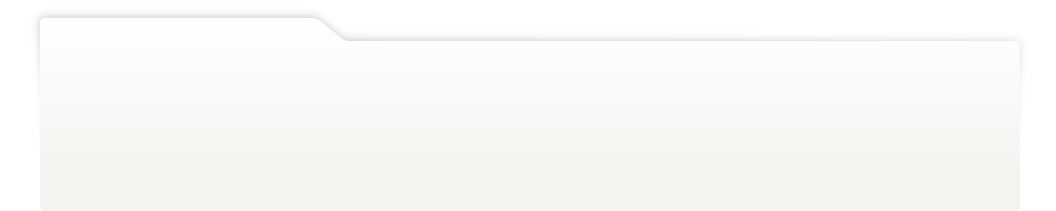
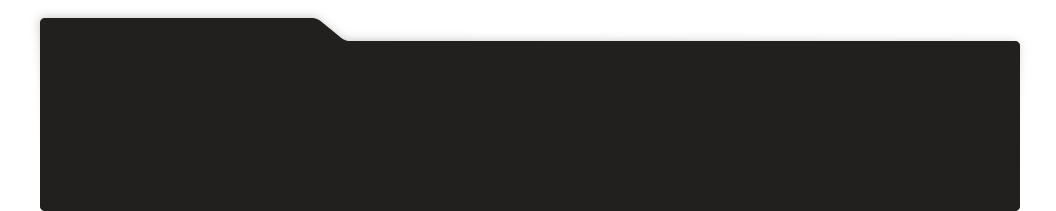
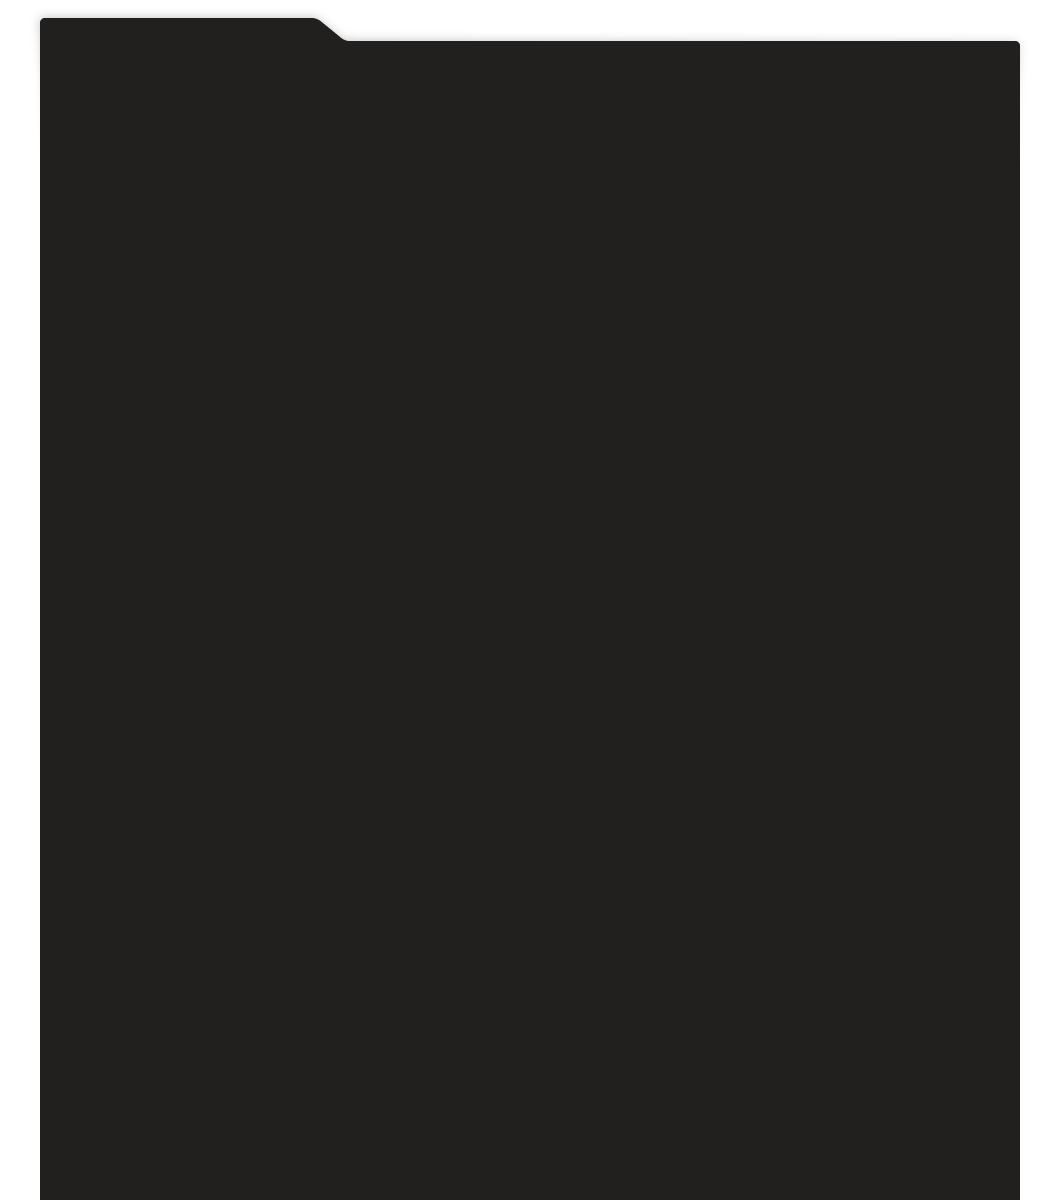
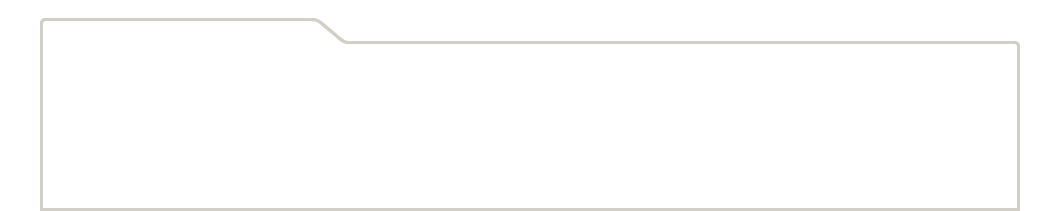
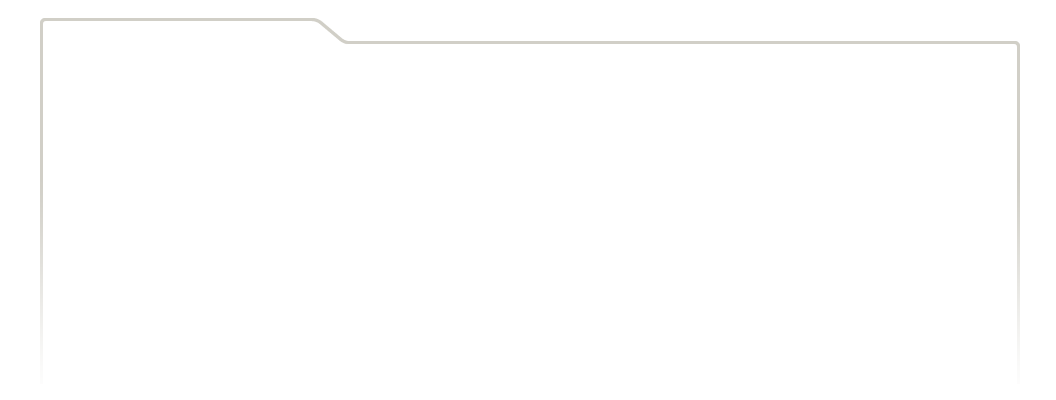
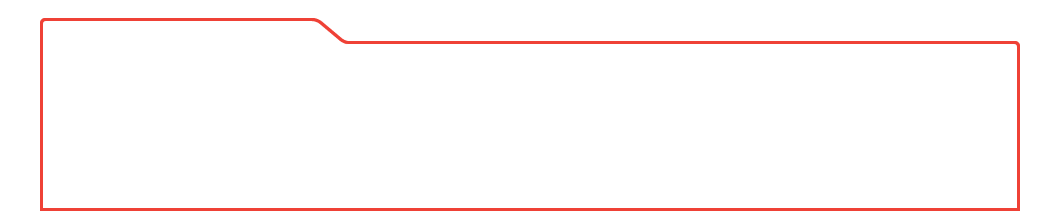
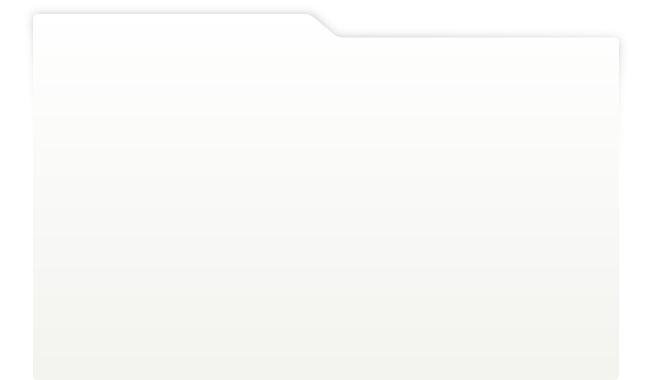
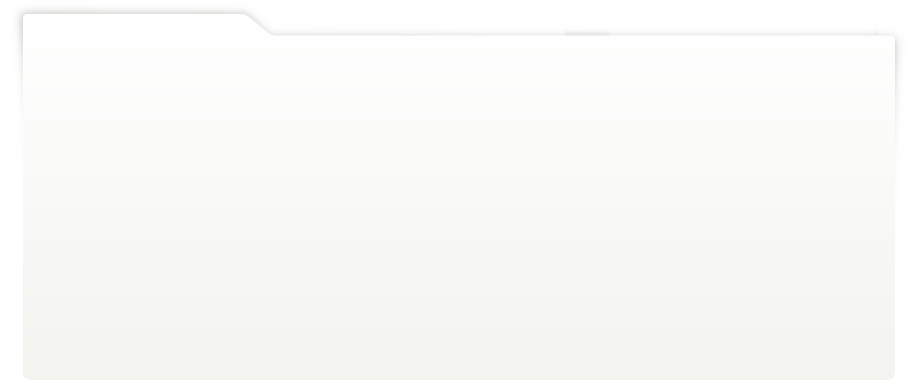
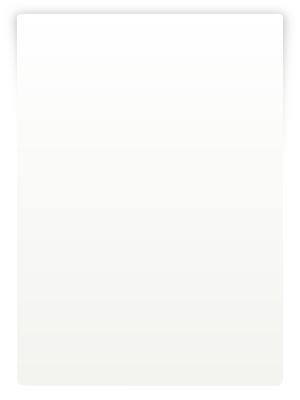
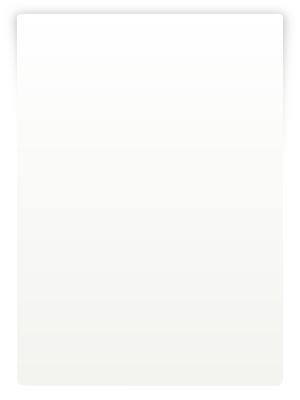
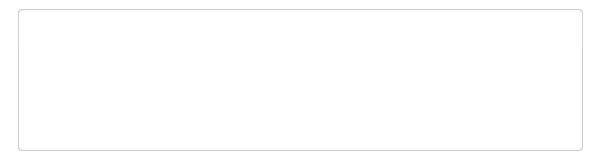
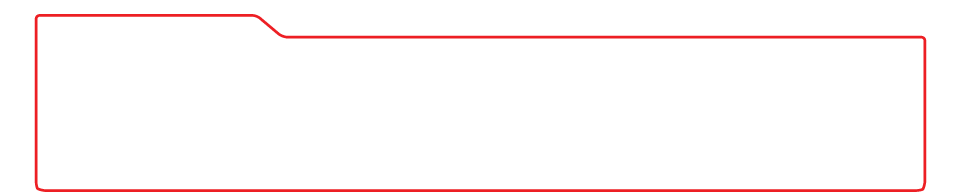
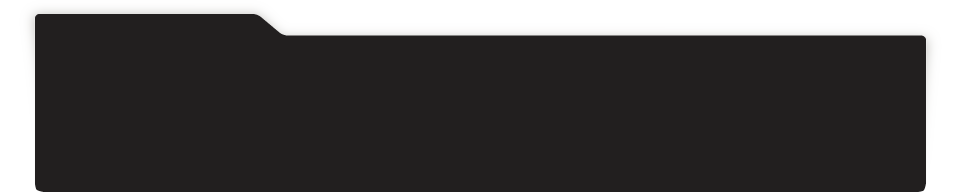
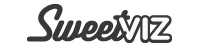
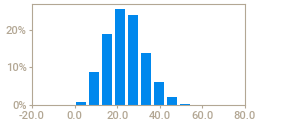
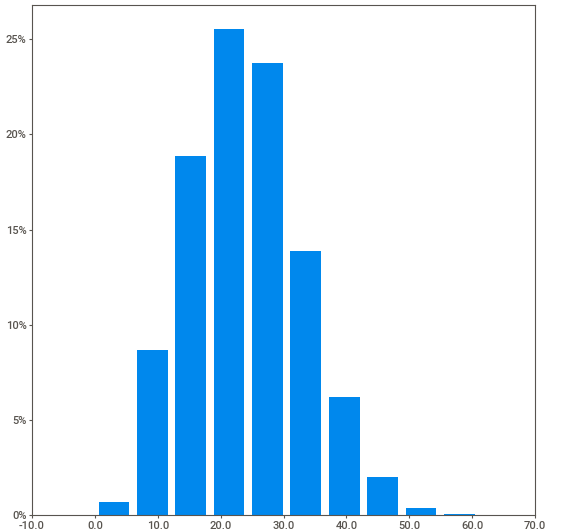
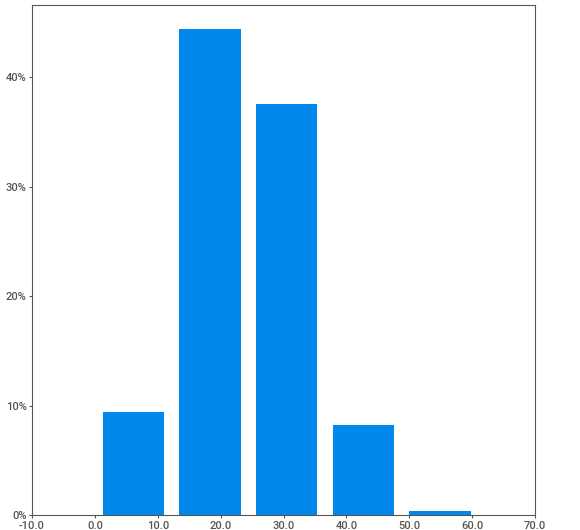
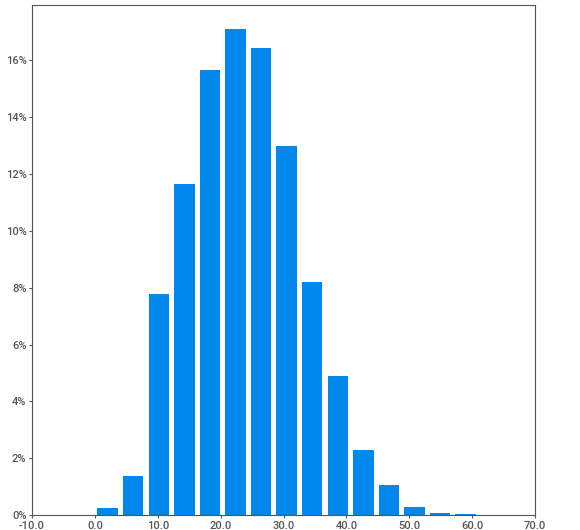
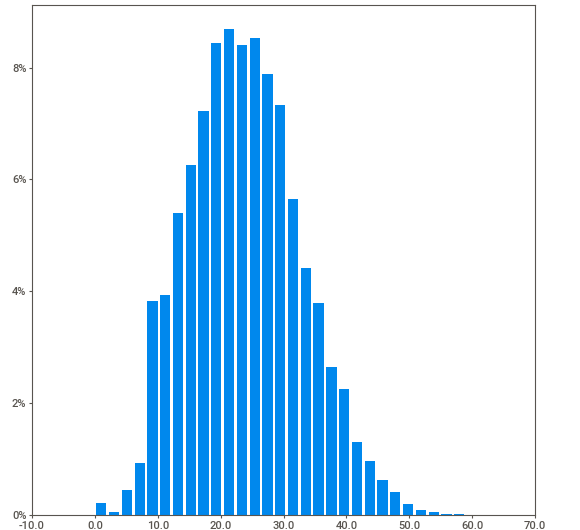
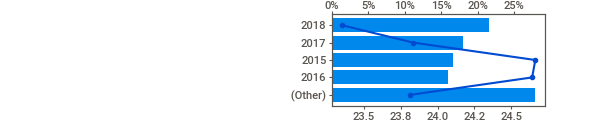
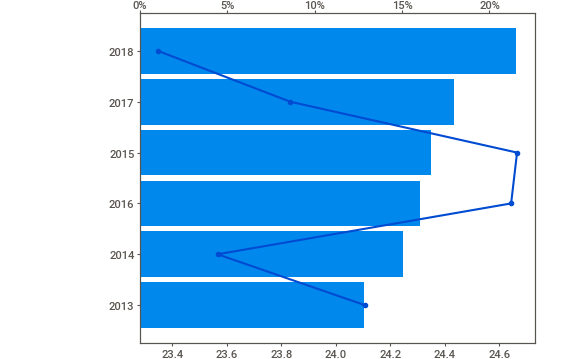
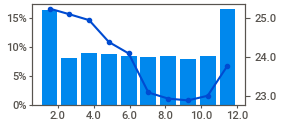
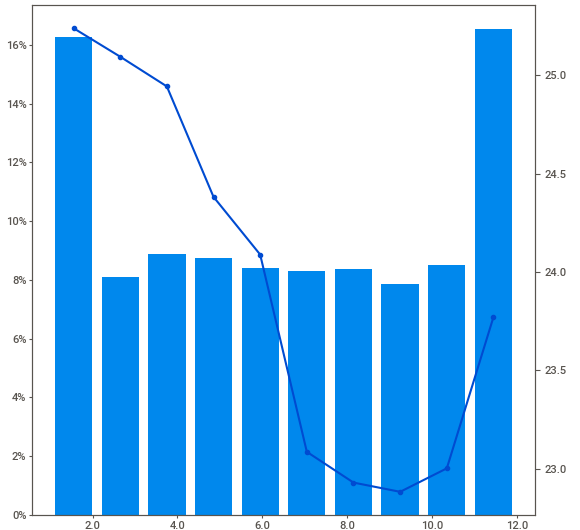
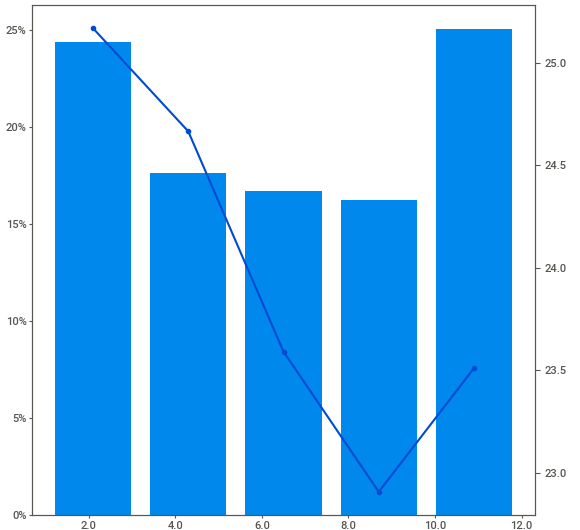
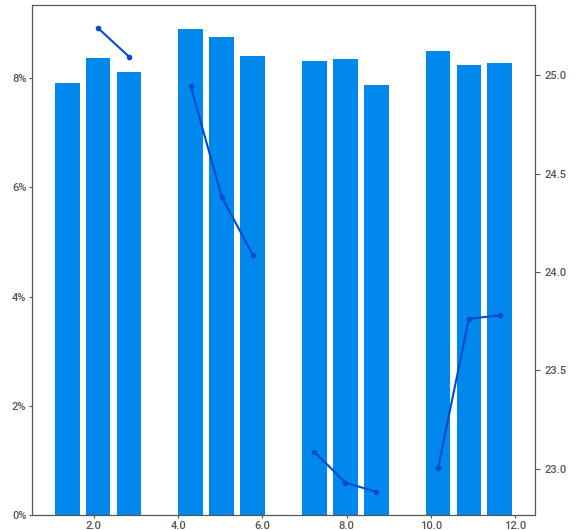
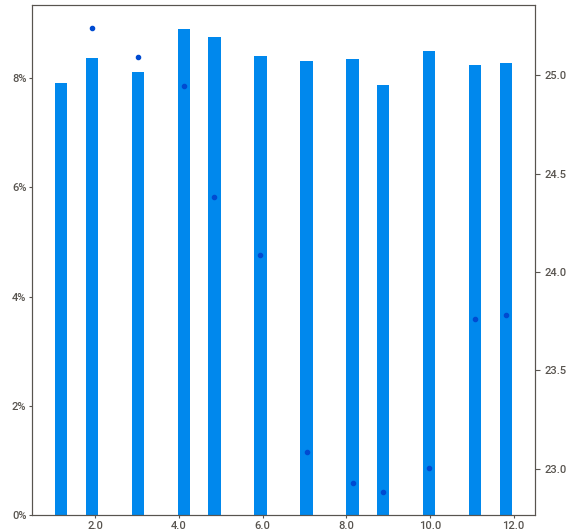
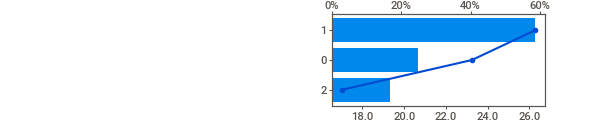
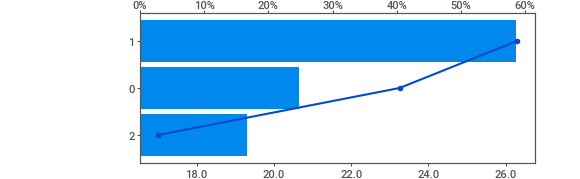
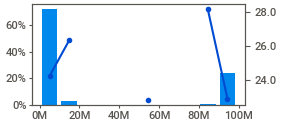
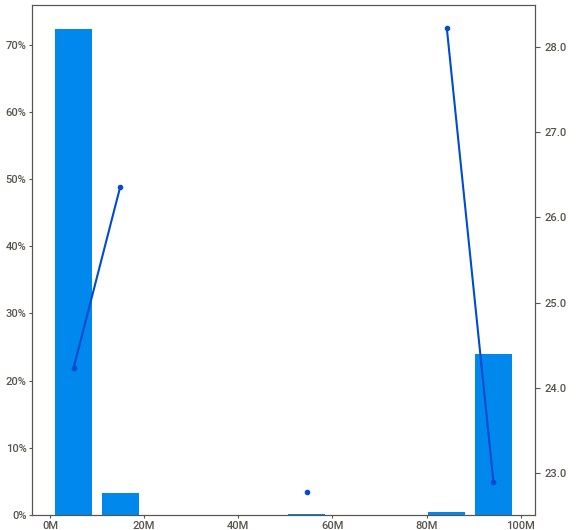
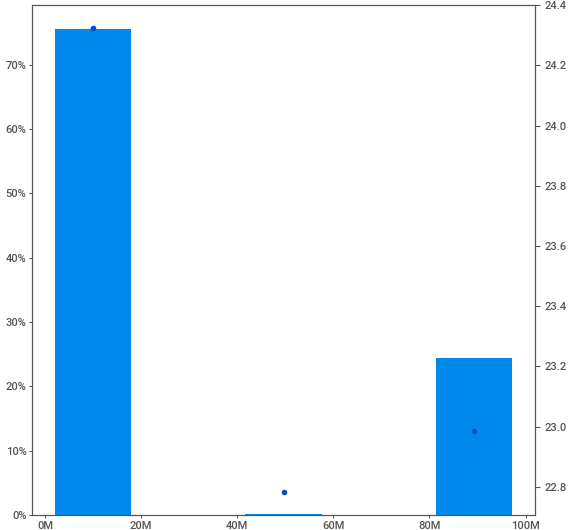
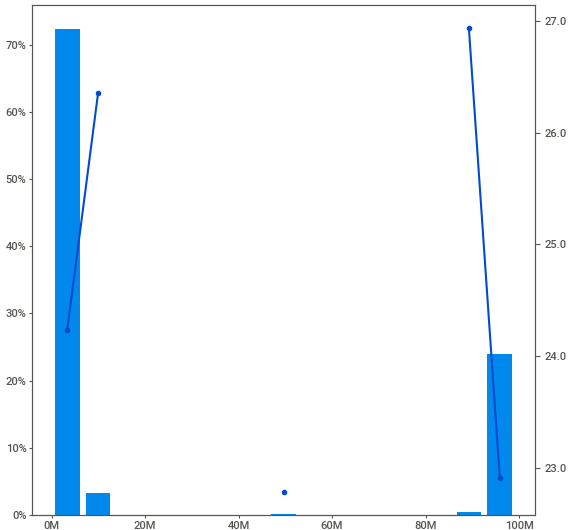
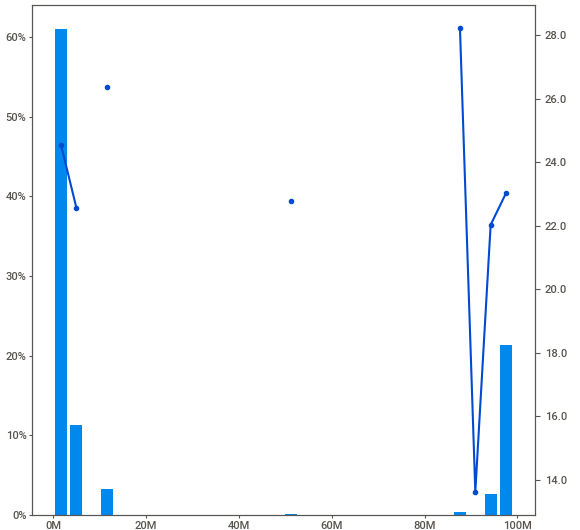
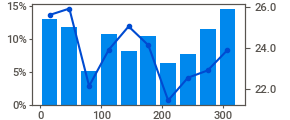
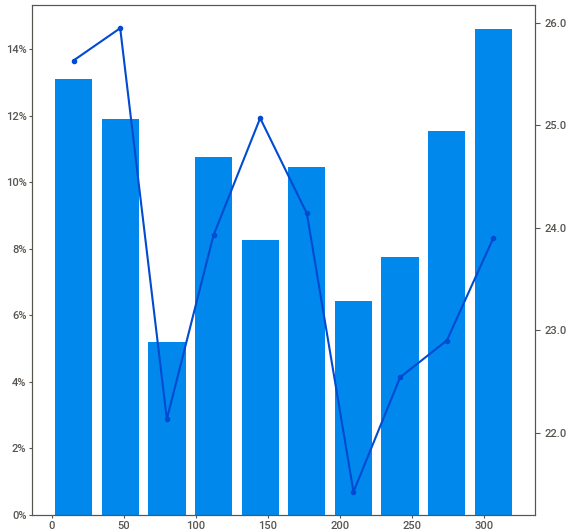
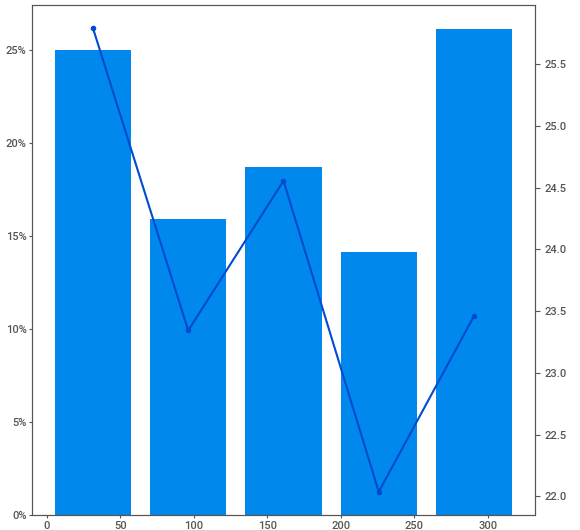
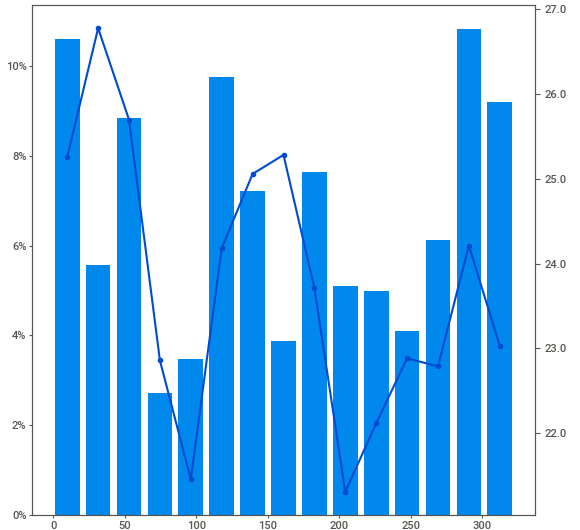
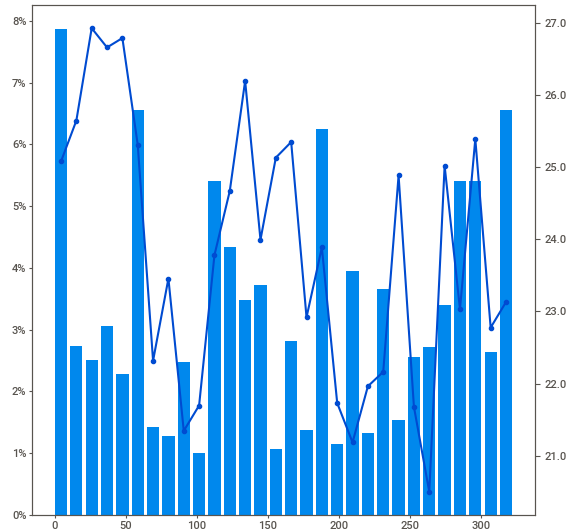
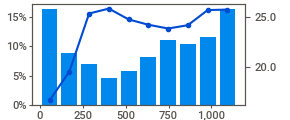
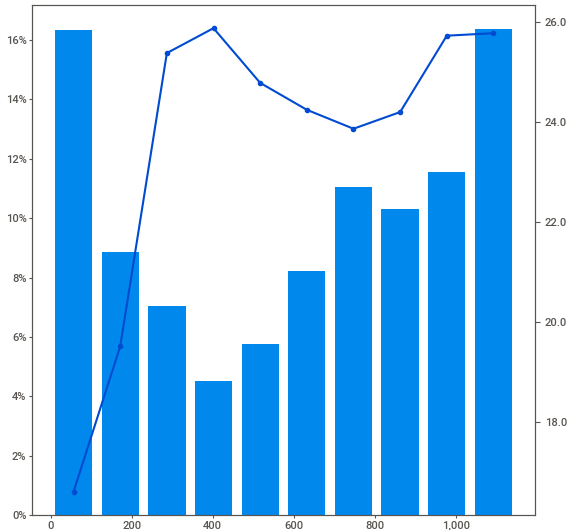
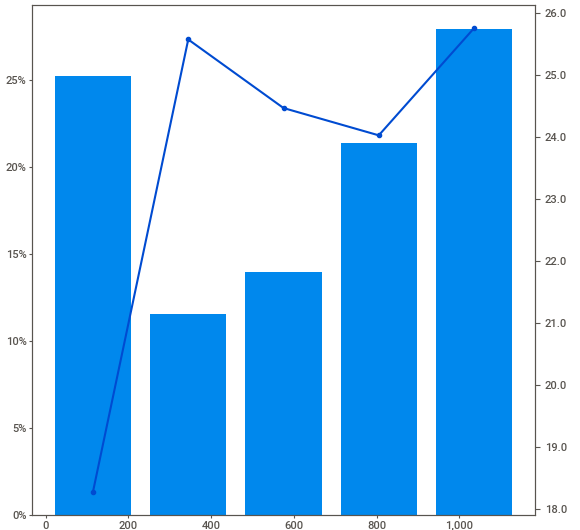
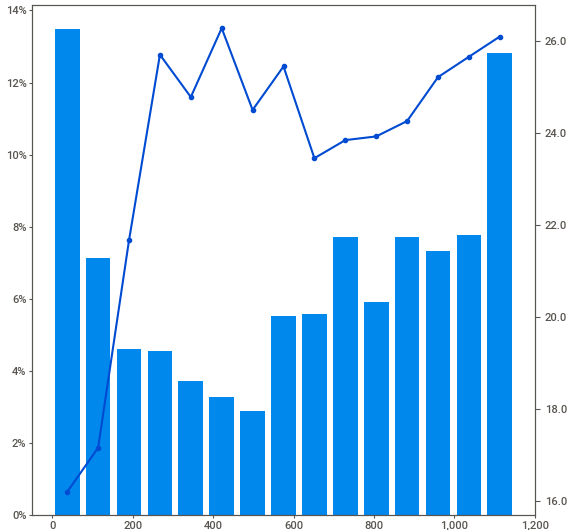
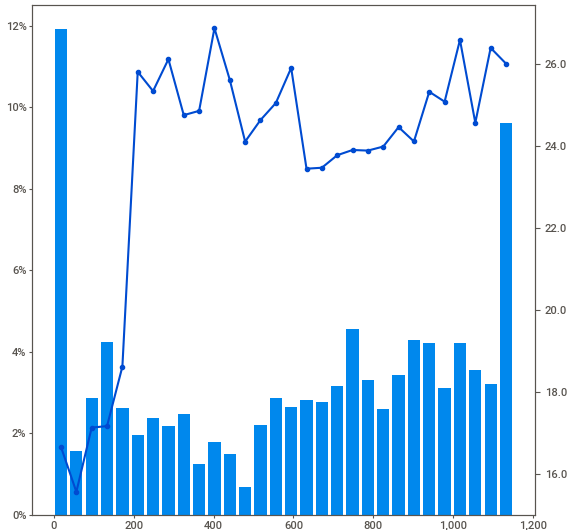
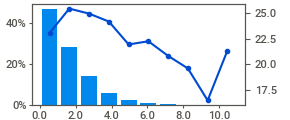
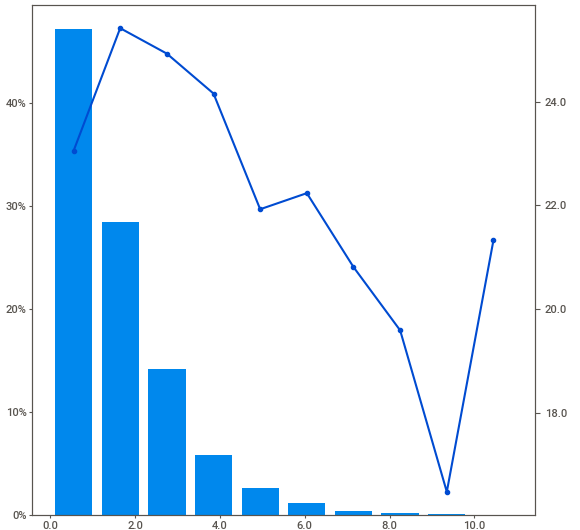
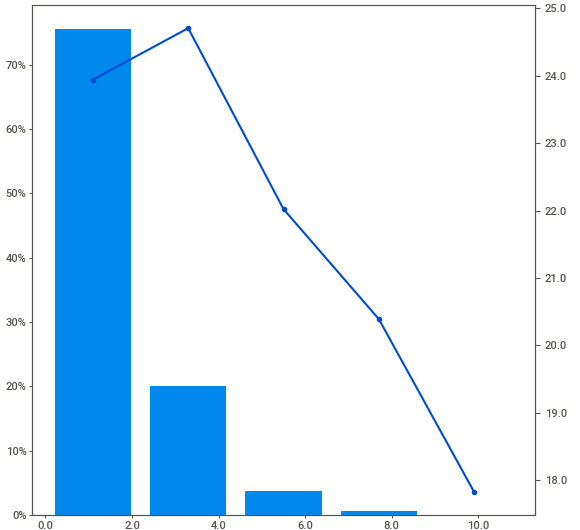
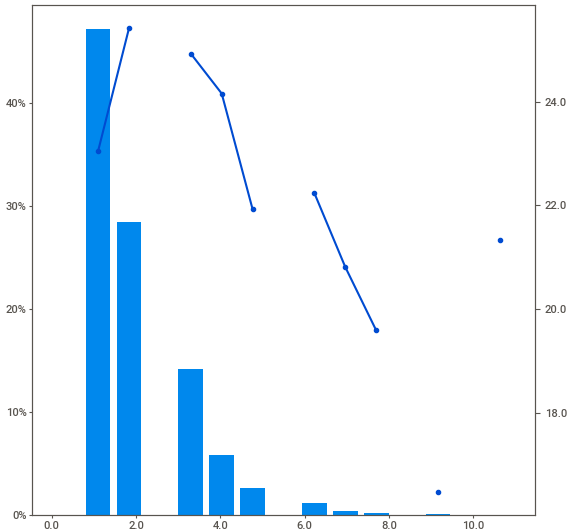
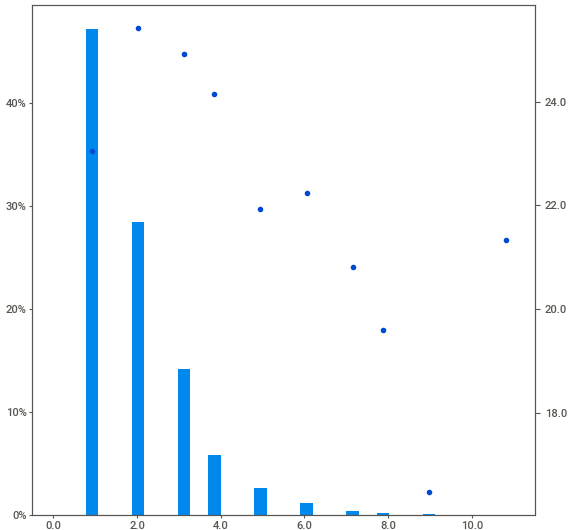
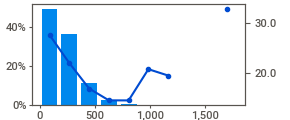
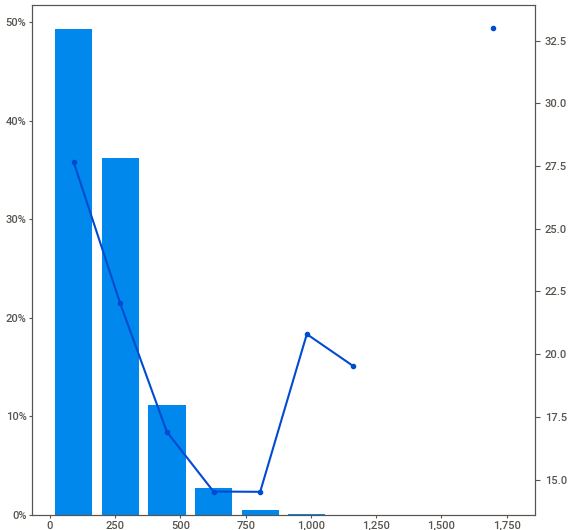
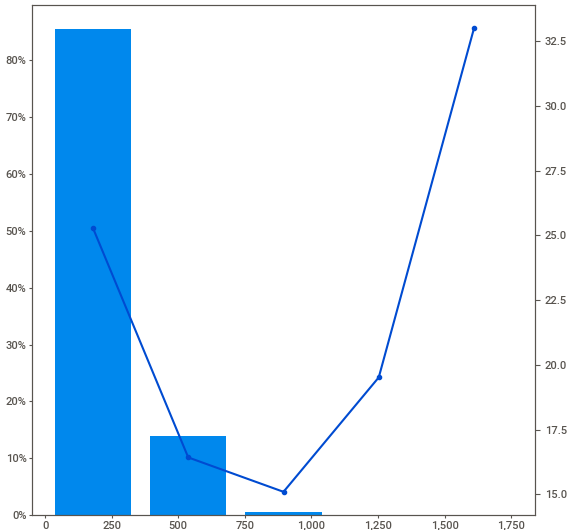
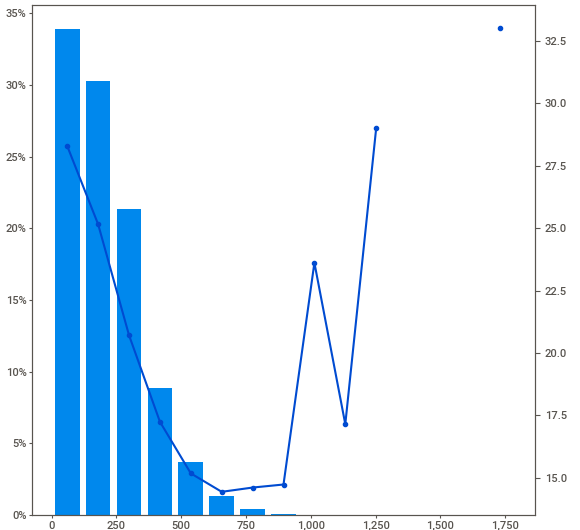
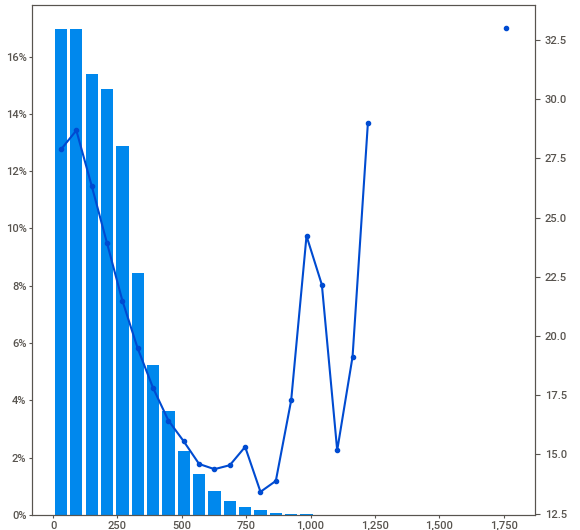
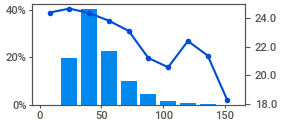
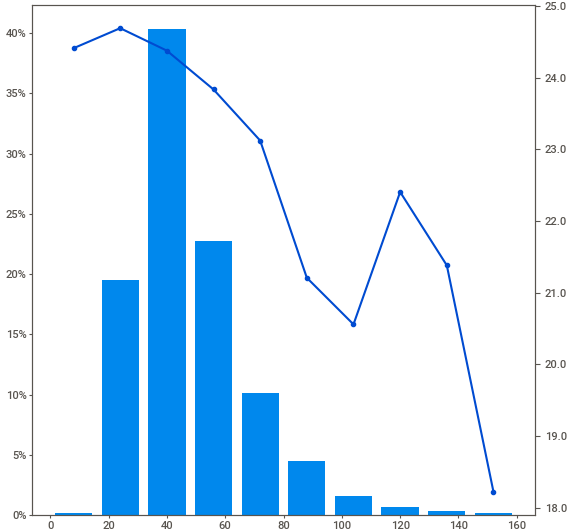
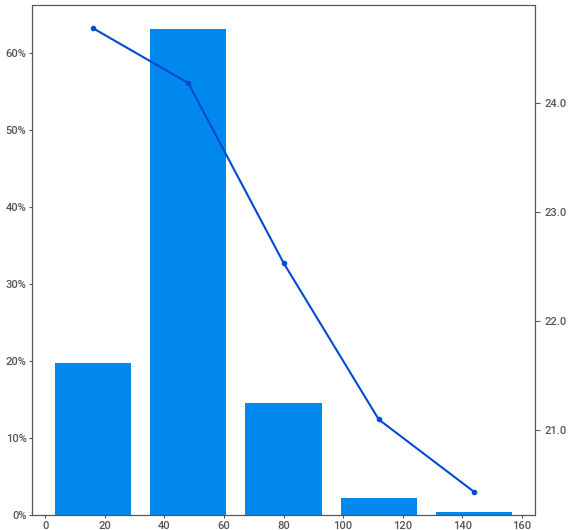
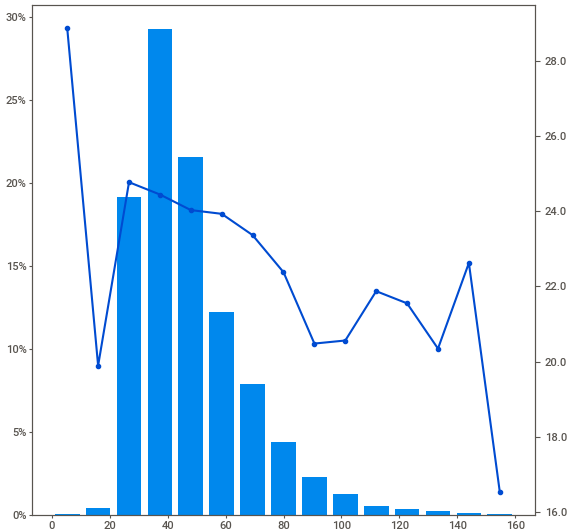
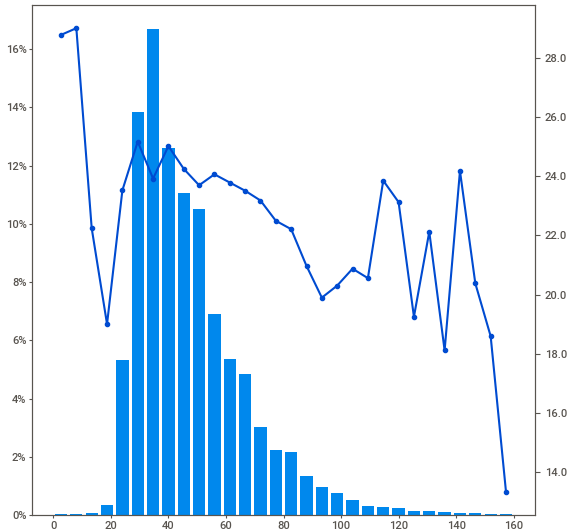
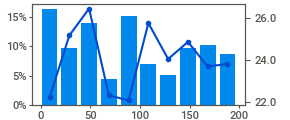
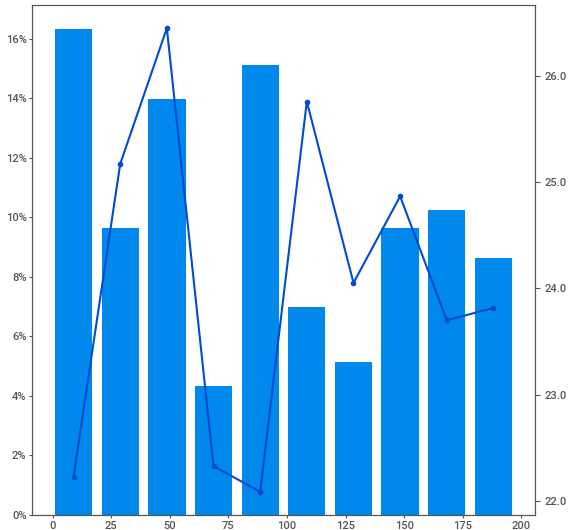
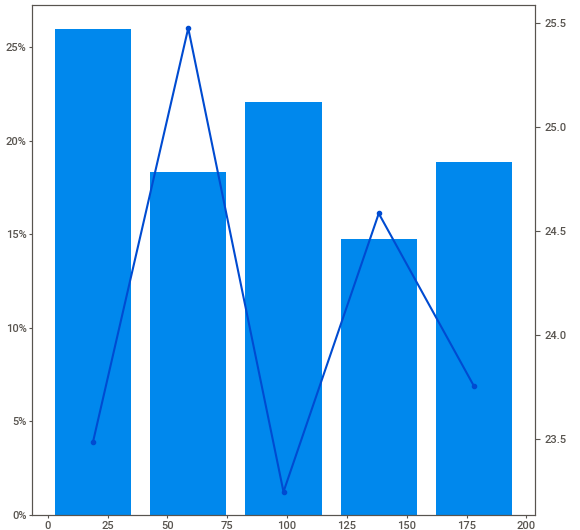
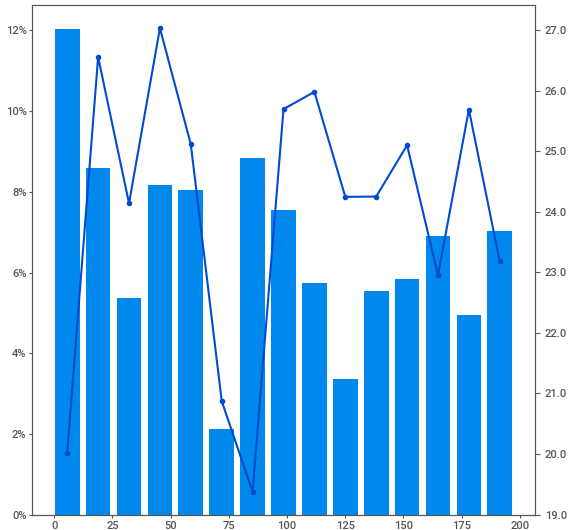
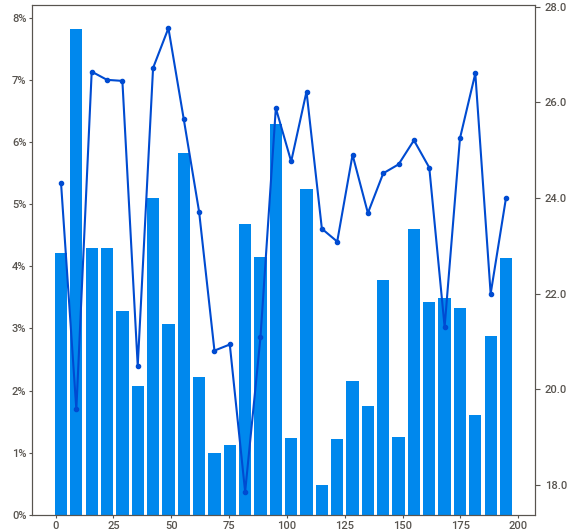
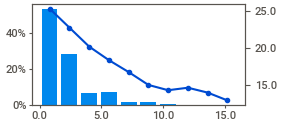
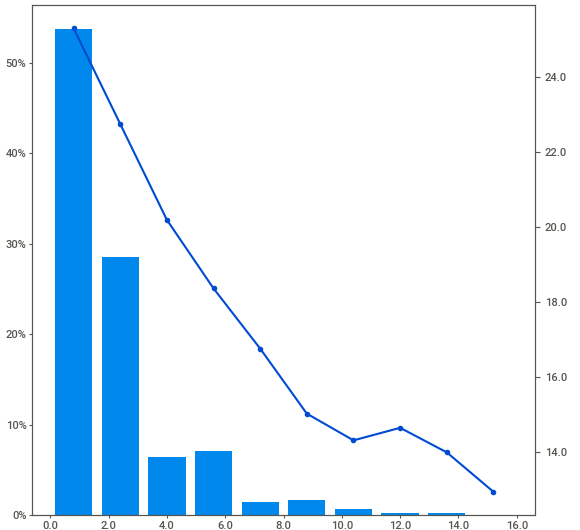
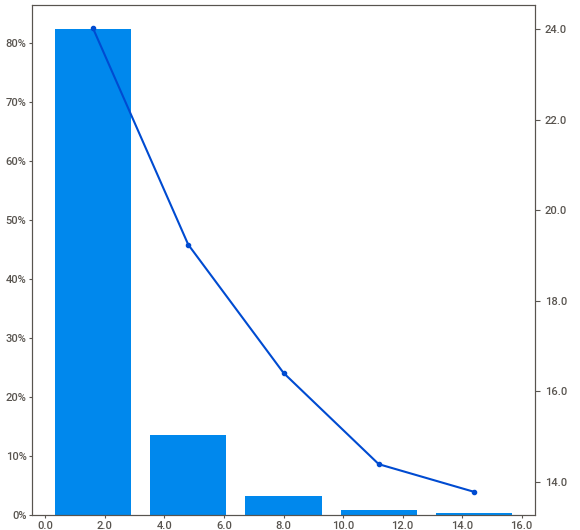
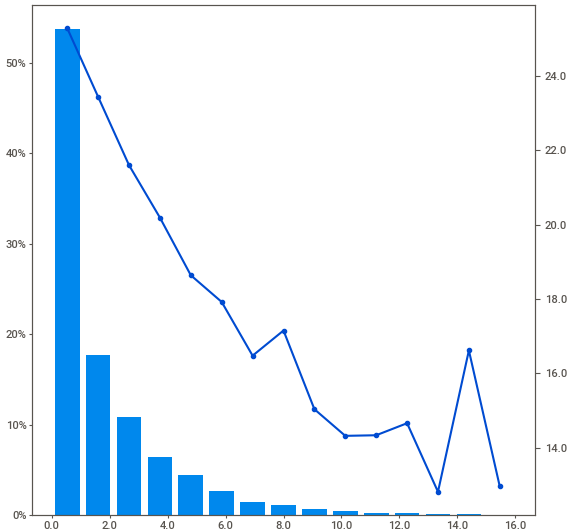
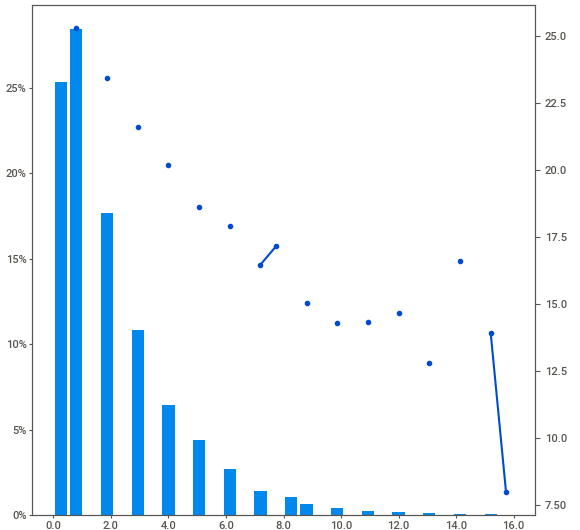
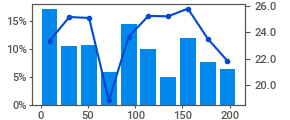
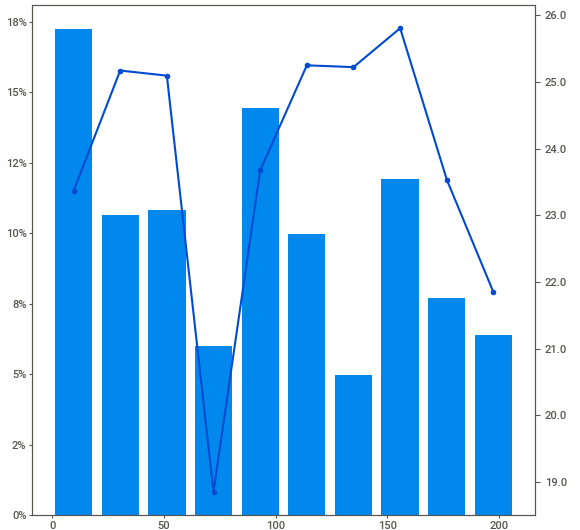
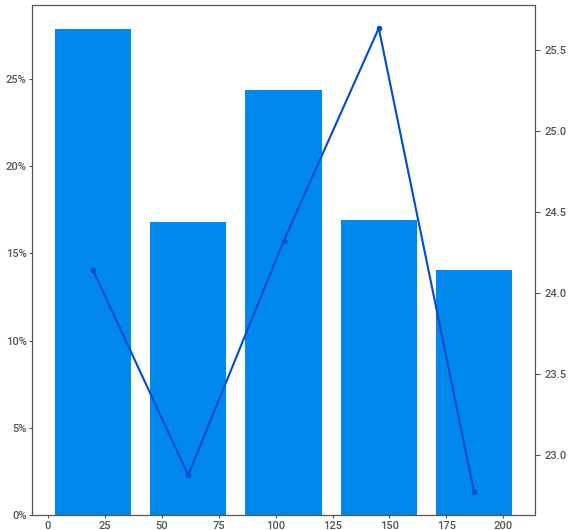
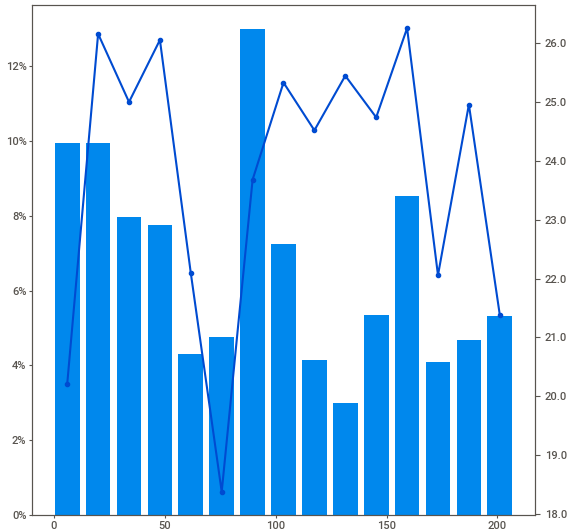
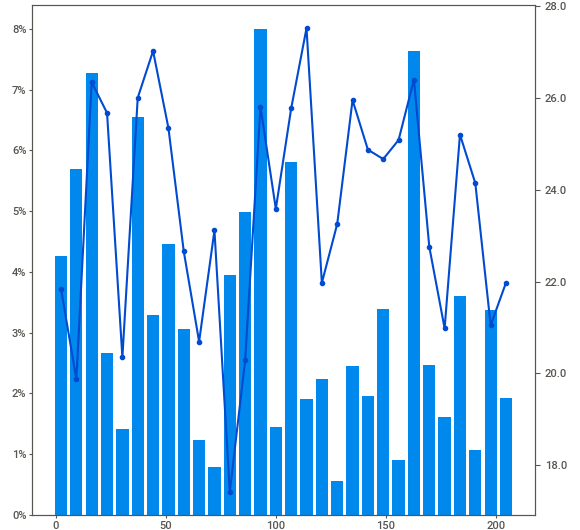
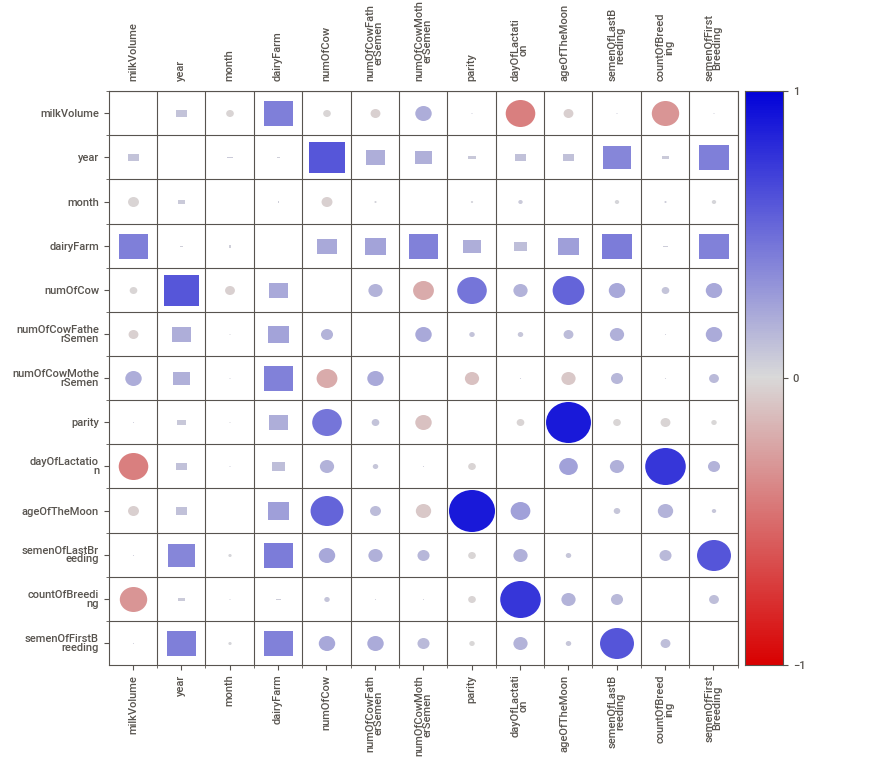
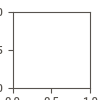

In [26]:
# 在沒有處理的情況下來自自資料的分析報告
reportDf_sv_report = sv.analyze(preReportDf, target_feat='milkVolume')
reportDf_sv_report.show_notebook()